In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Set plotting parameters
plt.rcParams['figure.dpi'] = 90
plt.rcParams.update({'font.size': 12})

In [ ]:
# Define environment size and actions
environment_rows, environment_columns = 4, 4
actions = ['up', 'right', 'down', 'left']

In [ ]:
# Initialize Q-values
q_values = np.zeros((environment_rows, environment_columns, 4))  # Grid size 4x4, 4 actions

# Initialize a delay matrix with random values between 1ms to 5ms (assuming each transition has a fixed time cost)
delays = np.random.randint(1, 6, (environment_rows, environment_columns, 4))

In [ ]:
class WRL:
    def __init__(self, Q, delays):
        self.Q = Q
        self.delays = delays

    def get_reward(self, row, column):
        rewards = np.full((environment_rows, environment_columns), -1)
        rewards[3, 3] = 50  # Goal position reward
        malicious = {(2, 0): -10, (3, 0): -10, (2, 2): -10, (0, 3): -10}
        return malicious.get((row, column), rewards[row, column])

    def is_terminal_state(self, current_row_index, current_column_index):
        return (current_row_index, current_column_index) in {(3, 3), (2, 0), (3, 0), (2, 2), (0, 3)}

    def get_starting_location(self):
        while True:
            row_index, column_index = np.random.randint(environment_rows), np.random.randint(environment_columns)
            if not self.is_terminal_state(row_index, column_index):
                return row_index, column_index

    def get_next_action(self, current_row_index, current_column_index, epsilon):
        if np.random.random() < epsilon:
            return np.random.randint(4)
        else:
            return np.argmax(self.Q[current_row_index, current_column_index])

    def get_next_location(self, current_row_index, current_column_index, action_index):
        new_row_index, new_column_index = current_row_index, current_column_index
        if actions[action_index] == 'up' and current_row_index > 0:
            new_row_index -= 1
        elif actions[action_index] == 'right' and current_column_index < environment_columns - 1:
            new_column_index += 1
        elif actions[action_index] == 'down' and current_row_index < environment_rows - 1:
            new_row_index += 1
        elif actions[action_index] == 'left' and current_column_index > 0:
            new_column_index -= 1
        return new_row_index, new_column_index

In [ ]:
def train_wrl(episodes, epsilon=1.0, epsilon_decay=0.0005, alpha=0.9, gamma=0.95, beta_balance=0.5, verbose=False):
    environment_rows = 4
    environment_columns = 4
    q_values = np.zeros((environment_rows, environment_columns, 4))
    delays = np.random.randint(1, 5, (environment_rows, environment_columns, 4))
    env = WRL(q_values, delays)

    rewards_per_episode = []
    pdr_per_episode = []
    total_delays = []
    average_delay_per_episode = []
    epsilon_per_episode = []
    packets_delivered = 0

    for i in range(episodes):
        row_index, col_index = env.get_starting_location()
        total_rewards = 0
        time_steps = 0

        while not env.is_terminal_state(row_index, col_index):
            action_index = env.get_next_action(row_index, col_index, epsilon)
            old_row_index, old_col_index = row_index, col_index
            new_row_index, new_col_index = env.get_next_location(row_index, col_index, action_index)

            # Ensure env.delays is accessed correctly as a 3D array
            delay = env.delays[old_row_index, old_col_index, action_index]
            time_steps += delay

            immediate_reward = env.get_reward(new_row_index, new_col_index)
            average_delay = np.mean(total_delays) if total_delays else 0
            custom_reward = beta_balance * (packets_delivered / (i + 1)) - (1 - beta_balance) * average_delay

            combined_reward = immediate_reward + custom_reward

            best_future_q = np.max(env.Q[new_row_index, new_col_index])
            env.Q[row_index, col_index, action_index] += alpha * (combined_reward + gamma * best_future_q - env.Q[row_index, col_index, action_index])

            row_index, col_index = new_row_index, new_col_index

            total_rewards += combined_reward

        if (row_index == 3 and col_index == 3):
            packets_delivered += 1
            total_delays.append(time_steps)

        pdr = packets_delivered / (i + 1)
        average_delay = np.mean(total_delays) if total_delays else 0
        rewards_per_episode.append(total_rewards)
        pdr_per_episode.append(pdr)
        average_delay_per_episode.append(average_delay)
        epsilon_per_episode.append(epsilon)
        epsilon = max(epsilon - epsilon_decay, 0.1)

        if verbose:
            print(f"Episode {i+1}: Reward = {total_rewards}, PDR = {pdr}, Average Delay = {average_delay}, Epsilon = {epsilon}")

    return env.Q, rewards_per_episode, pdr_per_episode, average_delay_per_episode, epsilon_per_episode

In [ ]:
episodes = 10000
q_values, rewards_per_episode, pdr_per_episode, average_delay_per_episode, epsilon_per_episode = train_wrl(episodes, verbose=False)
print(f"Out of {episodes} episodes, the agent reached the goal state {pdr_per_episode[-1]*episodes:.0f} times.")
print(f"Packet Delivery Rate (PDR): {pdr_per_episode[-1]:.2f}")
print(f"Average Delay : {average_delay_per_episode[-1]} ms")

Out of 10000 episodes, the agent reached the goal state 8508 times.
Packet Delivery Rate (PDR): 0.85
Average Delay : 7.292430653502586 ms


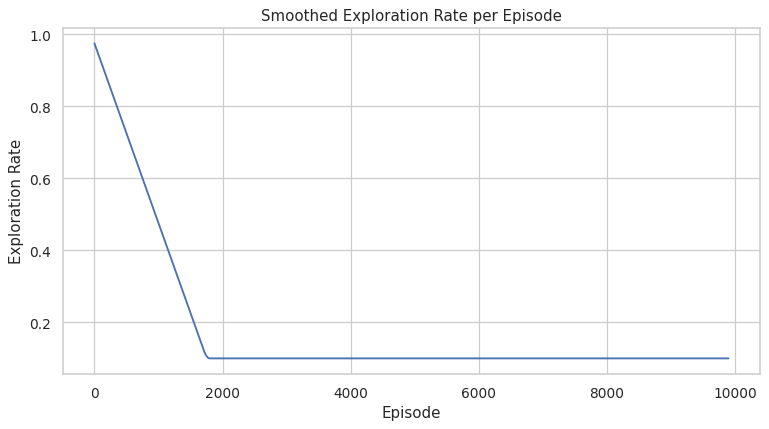

In [ ]:
sns.set(style="whitegrid")
def moving_average(values, window_size):
    cumsum_vec = np.cumsum(np.insert(values, 0, 0))  # Add zero at the beginning for proper cumsum calculation
    return (cumsum_vec[window_size:] - cumsum_vec[:-window_size]) / window_size

smoothed_exploration_rates = moving_average(epsilon_per_episode, 100)  # Smoothing over 100 episodes

# Plotting the smoothed exploration rates
plt.figure(figsize=(10, 5))
plt.plot(smoothed_exploration_rates)
plt.title('Smoothed Exploration Rate per Episode')
plt.xlabel('Episode')
plt.ylabel('Exploration Rate')
plt.show()


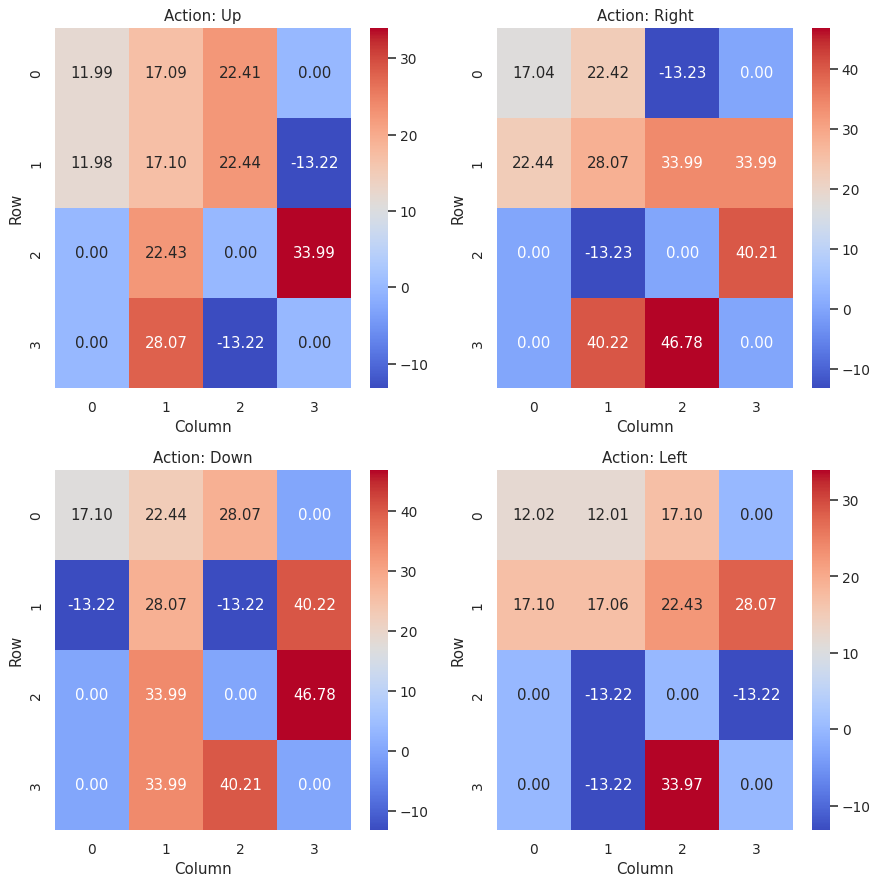

In [ ]:
def plot_q_values(Q):
    # Create a figure with subplots arranged in a 2x2 grid
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    # Titles for each subplot based on the action they represent
    action_titles = ['Up', 'Right', 'Down', 'Left']

    # Iterate over all actions and plot each Q-value table as a heatmap
    for i, ax in enumerate(axs.flat):
        # Use seaborn to plot the heatmap
        sns.heatmap(Q[:, :, i], annot=True, fmt=".2f", cmap="coolwarm", ax=ax)
        ax.set_title(f"Action: {action_titles[i]}")
        ax.set_xlabel('Column')
        ax.set_ylabel('Row')

    # Improve layout to prevent overlap and show plots
    plt.tight_layout()
    plt.show()

# Call the function to plot Q-values
# This line assumes `q_values` is defined in your notebook environment after training
plot_q_values(q_values)

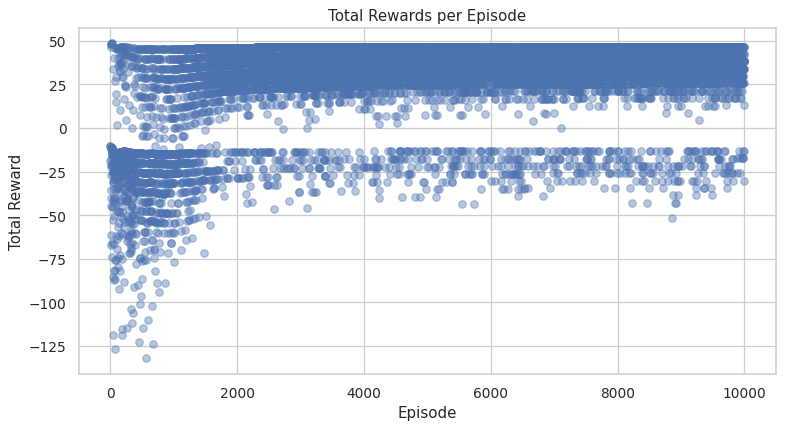

In [ ]:
sns.set(style="whitegrid")
# Create a new figure with a specified size
plt.figure(figsize=(10, 5))

# Create a scatter plot. 'range(len(rewards_per_episode))' generates x-values from 0 to the length of your rewards list
plt.scatter(range(len(rewards_per_episode)), rewards_per_episode, alpha = 0.4)  # alpha is used to adjust the transparency

# Set the labels and title for the plot
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Total Rewards per Episode")

# Display the plot
plt.show()

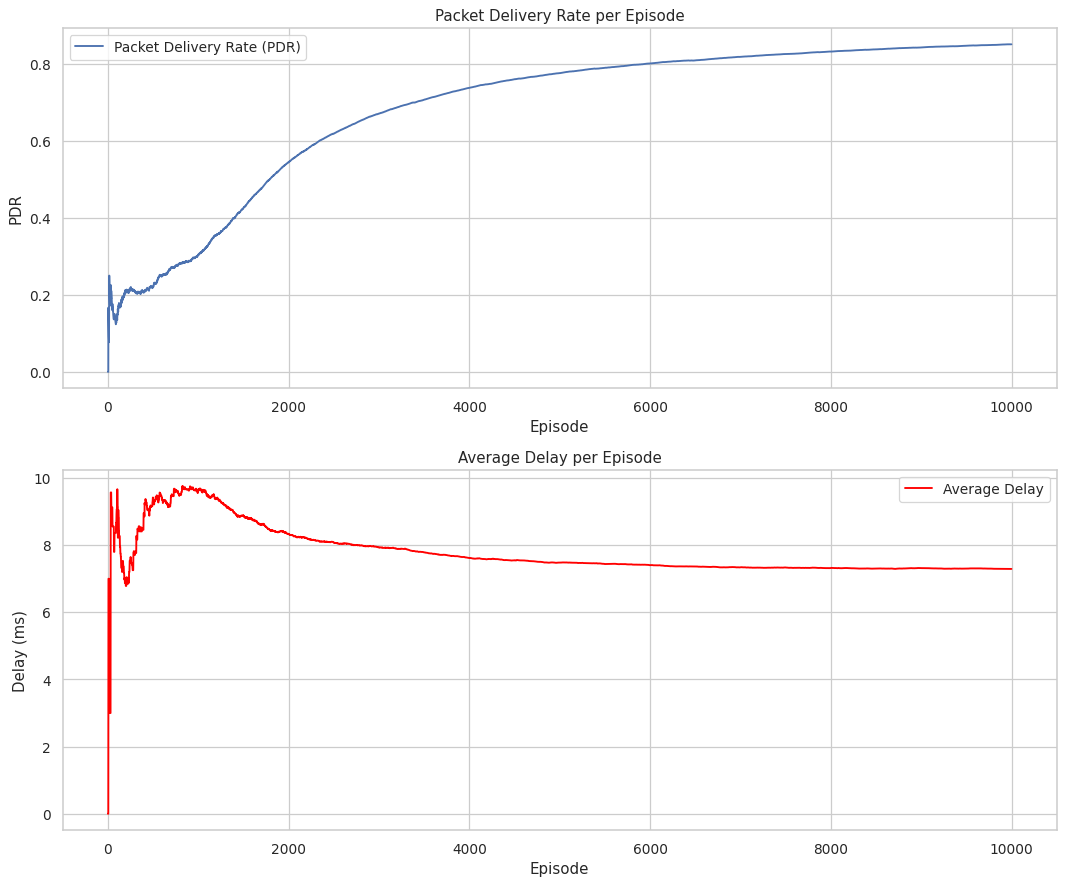

In [ ]:
# PDR and Delay
sns.set(style="whitegrid")
plt.rcParams.update({'figure.dpi': 90, 'font.size': 12})
fig, axs = plt.subplots(2, 1, figsize=(12, 10))
axs[0].plot(pdr_per_episode, label='Packet Delivery Rate (PDR)')
axs[0].set_title('Packet Delivery Rate per Episode')
axs[0].set_xlabel('Episode')
axs[0].set_ylabel('PDR')
axs[0].legend()

axs[1].plot(average_delay_per_episode, label='Average Delay', color='red')
axs[1].set_title('Average Delay per Episode')
axs[1].set_xlabel('Episode')
axs[1].set_ylabel('Delay (ms)')
axs[1].legend()

plt.tight_layout()
plt.show()

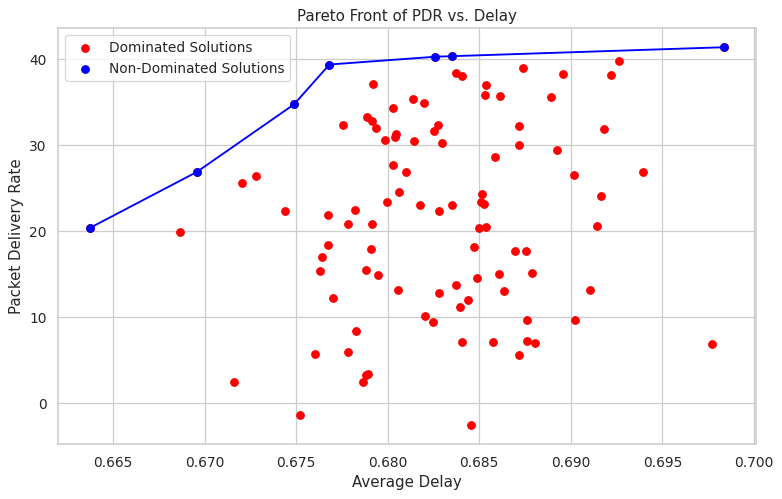

In [ ]:
# Pareto front calculation and plotting
betas = np.linspace(0, 1, 100)
results = [train_wrl(10000, beta_balance=b) for b in betas]

# Extract average PDRs and Delays
pdrs = [np.mean(result[1]) for result in results]
delays = [np.mean(result[2]) for result in results]


def find_pareto_points(delays, pdrs):
    points = list(zip(delays, pdrs))
    pareto_front = []

    for point in points:
        is_dominated = False
        for other in points:
            if other != point:
                if (other[1] > point[1]) and (other[0] < point[0]):
                    is_dominated = True
                    break
        if not is_dominated:
            pareto_front.append(point)

    if pareto_front:
        pareto_front.sort()
        pareto_delays, pareto_pdrs = zip(*pareto_front)
        return pareto_delays, pareto_pdrs
    else:
        return [], []

pareto_delays, pareto_pdrs = find_pareto_points(delays, pdrs)

plt.figure(figsize=(10, 6))
plt.scatter(delays, pdrs, color='red', label='Dominated Solutions')
if pareto_delays and pareto_pdrs:
    plt.scatter(pareto_delays, pareto_pdrs, color='blue', label='Non-Dominated Solutions')
    plt.plot(pareto_delays, pareto_pdrs, color='blue')
plt.title('Pareto Front of PDR vs. Delay')
plt.xlabel('Average Delay')
plt.ylabel('Packet Delivery Rate')
plt.legend()
plt.show()

In [ ]:
df = pd.DataFrame({
    'Beta': betas,
    'Average PDR': pdrs,
    'Average Delay': delays
})

# Display the DataFrame
print(df.to_string(index=False))

    Beta  Average PDR  Average Delay
0.000000    -1.394007       0.675228
0.010101     5.788438       0.676020
0.020202     7.002397       0.688033
0.030303    -2.523163       0.684543
0.040404    13.067278       0.686356
0.050505     3.310240       0.678843
0.060606     8.419187       0.678250
0.070707    11.190286       0.683950
0.080808     2.539765       0.678627
0.090909    10.136038       0.682057
0.101010    13.132933       0.680587
0.111111     9.748968       0.687587
0.121212     2.547172       0.671599
0.131313     9.732183       0.690238
0.141414     7.147766       0.685750
0.151515     5.603710       0.687183
0.161616     6.899957       0.697736
0.171717     9.429254       0.682491
0.181818    15.165151       0.687885
0.191919     3.384379       0.678929
0.202020     7.088825       0.684079
0.212121    13.753076       0.683706
0.222222    17.744439       0.687560
0.232323    17.758104       0.686951
0.242424     6.013499       0.677842
0.252525     7.221833       0.687603
0